# Find tables in picture-textfile

First import all required packages

In [1]:
# general tools
import os, sys
import numpy as np

In [2]:
import cv2

In [3]:
from IPython.display import Image

In [4]:
import imutils
import matplotlib.pyplot as plt

In [5]:
# tools for OCR
import pytesseract
from pytesseract import image_to_string

## Determine table structure

In [6]:
# define image name
img_name = "example_subtable_rot_numbers.png"
# define path where image is stored
src_path = './'

first we look at the file:

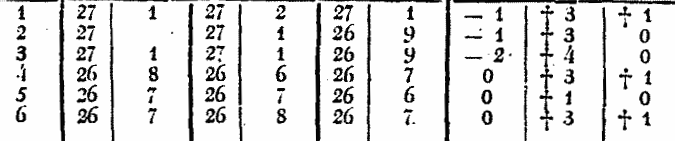

In [7]:
Image(filename=img_name) 

In [8]:
# now we read the file
img = cv2.imread(os.path.join(src_path,img_name))

### Naive reading

In [9]:
# now we use tesseract for character recognition
extxt = pytesseract.image_to_string(img, config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')

In [10]:
extxt

'Par aR ERATE'

# Try contour finding

This only works if there's only one table on a page
Important parameters:
 - morph_size
 - min_text_height_limit
 - max_text_height_limit
 - cell_threshold
 - min_columns

#### Subroutines

In [11]:
def pre_process_image(img, save_in_file, morph_size=(8, 8)):

    # get rid of the color
    pre = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Otsu threshold
    pre = cv2.threshold(pre, 250, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # dilate the text to make it solid spot
    cpy = pre.copy()
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    cpy = cv2.dilate(~cpy, struct, anchor=(-1, -1), iterations=1)
    pre = ~cpy

    if save_in_file is not None:
        cv2.imwrite(save_in_file, pre)
    return pre

In [12]:
def find_text_boxes(pre, min_text_height_limit=10, max_text_height_limit=40):
    # Looking for the text spots contours
    contours = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #contours = contours[0] if imutils.is_cv2() else contours[1]
    contours = contours[0]

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes

In [13]:
def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells

In [14]:
def build_lines(table_cells):
    if table_cells is None or len(table_cells) <= 0:
        return [], []

    max_last_col_width_row = max(table_cells, key=lambda b: b[-1][2])
    max_x = max_last_col_width_row[-1][0] + max_last_col_width_row[-1][2]

    max_last_row_height_box = max(table_cells[-1], key=lambda b: b[3])
    max_y = max_last_row_height_box[1] + max_last_row_height_box[3]

    hor_lines = []
    ver_lines = []

    for box in table_cells:
        x = box[0][0]
        y = box[0][1]
        hor_lines.append((x, y, max_x, y))

    for box in table_cells[0]:
        x = box[0]
        y = box[1]
        ver_lines.append((x, y, x, max_y))

    (x, y, w, h) = table_cells[0][-1]
    ver_lines.append((max_x, y, max_x, max_y))
    (x, y, w, h) = table_cells[0][0]
    hor_lines.append((x, max_y, max_x, max_y))

    return hor_lines, ver_lines

#### Main part

In [15]:
pre_file = os.path.join("./", "pre.png")
out_file = os.path.join("./", "out.png")

In [16]:
pre_processed = pre_process_image(img, pre_file, morph_size=(6,2))

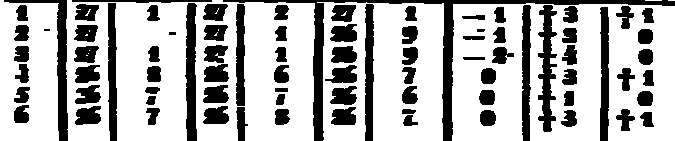

In [17]:
Image(filename=pre_file)

In [18]:
text_boxes = find_text_boxes(pre_processed, min_text_height_limit=12, max_text_height_limit=40)

In [19]:
cells = find_table_in_boxes(text_boxes, min_columns=2, cell_threshold=20)

In [20]:
hor_lines, ver_lines = build_lines(cells)

In [21]:
# Visualize the result
vis = img.copy()

for box in text_boxes:
    (x, y, w, h) = box
    cv2.rectangle(vis, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

for line in hor_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

for line in ver_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

cv2.imwrite(out_file, vis)

True

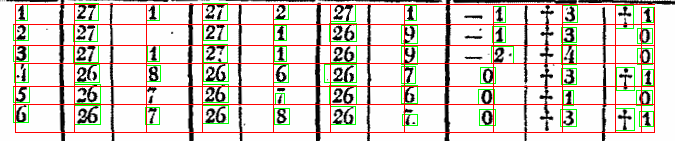

In [22]:
Image(filename=out_file)

## Read text in table

Now we have the table structure and we can get individual text boxes...

In [23]:
print(len(text_boxes))
text_boxes[0]

61


(402, 114, 17, 13)

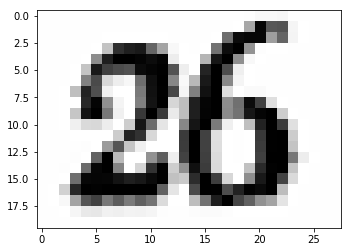

In [24]:
index = 18
image = img.copy()
box = text_boxes[index]
(x, y, w, h) = box
crop = image[y:y+h, x:x+w]
plt.imshow(crop)

In [25]:
# tesseract options 0 for testing
extxt = pytesseract.image_to_string(crop)
extxt

''

In [26]:
# tesseract options 0 for testing
extxt = pytesseract.image_to_string(crop, lang='deu_frak')
extxt

''

In [27]:
# tesseract options 1 for testing
text = pytesseract.image_to_string(crop, lang='deu',config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
print(text)

26


In [28]:
# tesseract options 2 for testing
text = pytesseract.image_to_string(crop,config='--psm 13')
print(text)

26


## Sort text boxes and print

Sort text boxes by x,y values before printing
Formatted printing will only work in this way if there is a uniform row/column size.

In [29]:
# convert to numpy array
npboxes = np.array(text_boxes)
#npboxes

In [30]:
y_sorted_boxes = sorted(npboxes, key=lambda x: (x[1]))
y_sorted_boxes
max_y = max(npboxes[:,1])
min_y = min(npboxes[:,1])
min_y,max_y

(3, 114)

In [31]:
n_inv = 6 # number of intervals (rows)
y_range = max_y-min_y
y_inv = int(y_range/n_inv)
y_inv

18

In [32]:
yr_boxes = []
y_old = y_sorted_boxes[0][1]-1
yr_boxes.append([])
index = 0
for box in y_sorted_boxes:
    y = box[1]
    y_diff = y-y_old
    if y_diff > y_inv*0.6:
        print(y_diff, index)
        yr_boxes.append([])
        index +=1
    y_old = y
    yr_boxes[index].append(box)
#yr_boxes

16 0
16 1
15 2
15 3
11 4


In [33]:
yx_boxes = []
for num in range(len(yr_boxes)):
    box = np.array(yr_boxes[num])
    yx_box = box[box[:,0].argsort()]
    yx_boxes.append(yx_box)
yx_boxes[1]

array([[ 13,  24,  17,  18],
       [ 73,  24,  26,  19],
       [203,  24,  26,  18],
       [274,  25,  14,  17],
       [329,  23,  29,  20],
       [401,  25,  18,  20],
       [492,  26,  15,  18],
       [561,  27,  17,  17],
       [637,  28,  17,  17]])

In [34]:
# printing loop
for num1 in range(len(yx_boxes)):
    for num2 in range(len(yx_boxes[num1])):
        box = yx_boxes[num1][num2]
        (x, y, w, h) = box
        crop = image[y:y+h, x:x+w]
        extxt = pytesseract.image_to_string(crop,config='--psm 13 --oem 3', lang='deu')
        # check whether digit option needs to be used
        is_number=True
        try: 
            int(extxt)
        except ValueError:
            is_number = False
            extxt = pytesseract.image_to_string(crop,lang='deu')
        sys.stdout.write('|%s|\t' % extxt)
    sys.stdout.write('\n\n')

|1|	|27|	|1|	|27|	|2|	|27|	|1|	||	|3|	||	|1|	

|2|	|27|	||	|4|	|26|	||	|1|	|3|	|0|	

|3|	|27|	|1|	|27|	|1|	|26|	||	||	|4|	|0|	

|4|	|26|	|8|	|26|	|6|	|26|	|7|	|0|	|3|	||	|1|	

|5|	|26|	|26|	||	|26|	|6|	||	|1|	||	

|6|	||	||	|26|	||	|26|	||	||	|3|	|7|	|1|	

